***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.2)** 16-D > 8-D (Coarse > FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\Google_Drive\Projects\Deep Learning\HD-CapsNet\Training_and_Analysis\1_EMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 64,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('1_EMNIST/HD_CapsNet/Mod_3_2')

# Import Dataset : FMNIST

In [6]:
dataset = datasets.E_MNIST(version = 'ALL') # importing Dataset
# dataset = datasets.E_MNIST(version = 'reduce') # importing Dataset

EMNIST dataset: Training have 112,800 samples and testing have 18,800 samples


## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'consistency_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss

def CustomLoss(y_true_c, y_true_f, y_pred_c, y_pred_f, LW_C, LW_F):
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    batch_loss = ML_c + ML_f
    return tf.reduce_mean(batch_loss)

## Architecture

In [10]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_2(input_shape     = dataset['x_train'].shape[1:], 
                                      input_shape_yc  = dataset['y_train_coarse'].shape[1:],
                                      input_shape_yf  = dataset['y_train_fine'].shape[1:], 
                                      no_coarse_class = number_of_classes_c,
                                      no_fine_class   = number_of_classes_f,
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8,
                                      SCap_c_dims     = 16
                                     )
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1],
                              y_true_f            = model.inputs[2], 
                              y_pred_c            = model.output[0],
                              y_pred_f            = model.output[1], 
                              LW_C                = lossweight['coarse_lw'],
                              LW_F                = lossweight['fine_lw']
                             )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 47)          0           ['prediction_fine[0][0]']        
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )                                                                                                
                                                                                                  
 tf.math.maximum_1 (TFOpLambda)  (None, 2)           0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_2level(dataset['x_train'],
                                                 dataset['y_train_coarse'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'], dataset['y_test_coarse'], dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_fine']]
                                          ),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1
                       )
    
    model.save_weights(model_save_dir)

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


## Model Analysis

In [26]:
final_model = keras.Model(model.inputs[:1], model.output)
# model.load_weights(directory+'/epoch-best.h5')
model.load_weights(directory+'/trained_model.h5')
lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']
                                 },

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

588/588 [==============================] - 10s 14ms/step - loss: 0.0454 - prediction_coarse_loss: 0.0440 - prediction_fine_loss: 0.0802 - prediction_coarse_accuracy: 0.9422 - prediction_fine_accuracy: 0.8939
1. loss ==> 0.045438252389431
2. prediction_coarse_loss ==> 0.043958403170108795
3. prediction_fine_loss ==> 0.08021365851163864
4. prediction_coarse_accuracy ==> 0.9422340393066406
5. prediction_fine_accuracy ==> 0.8938829898834229
588/588 [==============================] - 6s 10ms/step


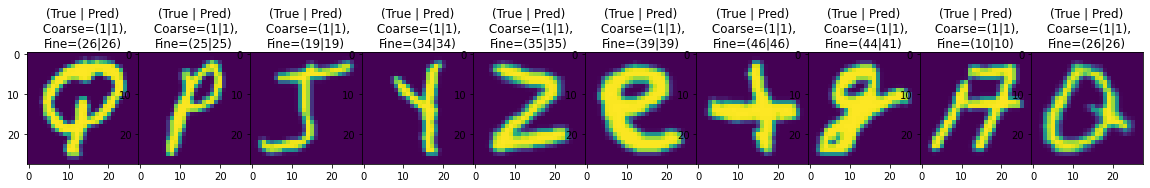

In [27]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 3442   558]
 [  528 14272]]

  • FINE LEVEL 
[[268   0   0 ...   0   0   0]
 [  0 223   0 ...   0   0   0]
 [  0   0 362 ...   1   0   0]
 ...
 [  0   0   0 ... 259   0   0]
 [  0   0   0 ...   0 374   1]
 [  0   0   0 ...   0   3 370]]

  • Classification Report 


  • COARSE LEVEL 


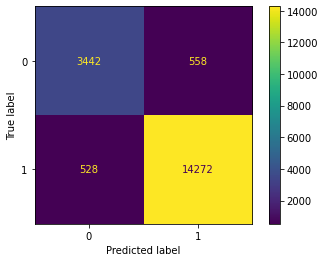

              precision    recall  f1-score   support

           0    0.86700   0.86050   0.86374      4000
           1    0.96237   0.96432   0.96335     14800

    accuracy                        0.94223     18800
   macro avg    0.91469   0.91241   0.91354     18800
weighted avg    0.94208   0.94223   0.94215     18800


  • FINE LEVEL 


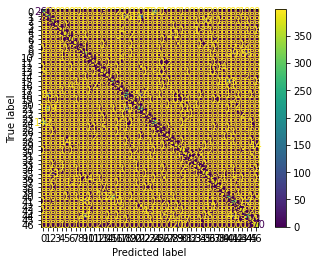

              precision    recall  f1-score   support

           0    0.63208   0.67000   0.65049       400
           1    0.53606   0.55750   0.54657       400
           2    0.91878   0.90500   0.91184       400
           3    0.99499   0.99250   0.99374       400
           4    0.96429   0.94500   0.95455       400
           5    0.95420   0.93750   0.94578       400
           6    0.95443   0.94250   0.94843       400
           7    0.97500   0.97500   0.97500       400
           8    0.96717   0.95750   0.96231       400
           9    0.72791   0.78250   0.75422       400
          10    0.97052   0.98750   0.97893       400
          11    0.97015   0.97500   0.97257       400
          12    0.96517   0.97000   0.96758       400
          13    0.95214   0.94500   0.94856       400
          14    0.98020   0.99000   0.98507       400
          15    0.69784   0.72750   0.71236       400
          16    0.93735   0.97250   0.95460       400
          17    0.96341   0

In [28]:
true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

In [29]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                                               pred_label,
                                                               dataset['tree']
                                                              )
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.9181382978723405 
Hierarchical Recall = 0.9198404255319149 
Hierarchical F1-Score = 0.9188191489361702 
Consistency =  0.993031914893617 
Exact Match =  0.8906382978723404
